In [1]:
#IMPORTY LIBRARIES FOR EDA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import spacy 
from textblob import TextBlob
import re
import warnings
from tqdm import tqdm
from datasets import load_dataset
import torch

device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
device

# Suppress warnings
warnings.filterwarnings('ignore')

/home/jnbelmonte/miniconda3/envs/fakenews_stable/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
df = pd.read_csv('/home/jnbelmonte/miniconda3/envs/fakenews_stable/Thesis_model_programs/roBERTa/fakenews_train_filtered_final.csv')

# Display basic information about the dataset
print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12821 entries, 0 to 12820
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  12821 non-null  object
 1   Authors   12821 non-null  object
 2   Date      12821 non-null  object
 3   Content   12821 non-null  object
 4   Brand     12821 non-null  object
 5   URL       12821 non-null  object
 6   Label     12821 non-null  object
dtypes: object(7)
memory usage: 701.3+ KB
None
                                                 Headline        Authors  \
count                                               12821          12821   
unique                                              11685            507   
top     Results, team standings: UAAP Season 86 volley...  ['Pol Pinoy']   
freq                                                   31           4012   

                    Date                                            Content  \
count              12821                   

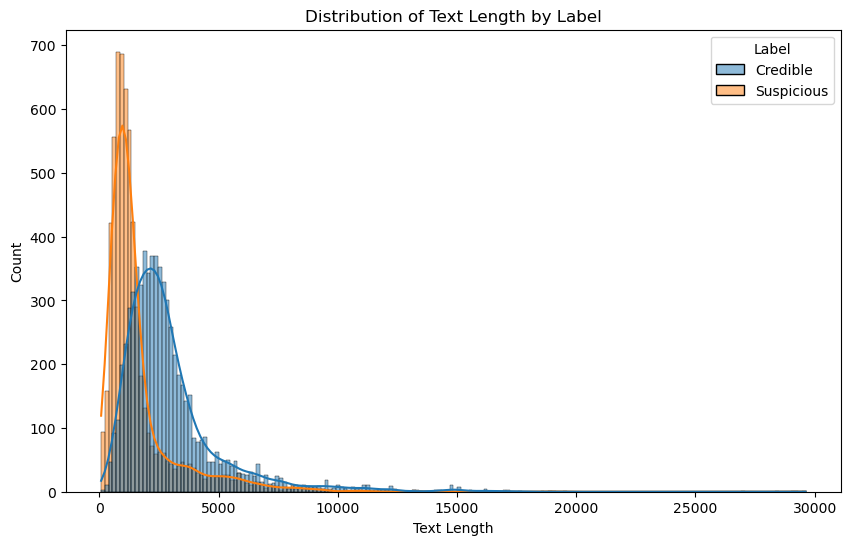

Average Content length: 2358.97
Median Content length: 1740.00


In [3]:
# Text length analysis
df['content_length'] = df['Content'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='content_length', hue='Label', kde=True)
plt.title('Distribution of Text Length by Label')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

print(f"Average Content length: {df['content_length'].mean():.2f}")
print(f"Median Content length: {df['content_length'].median():.2f}")

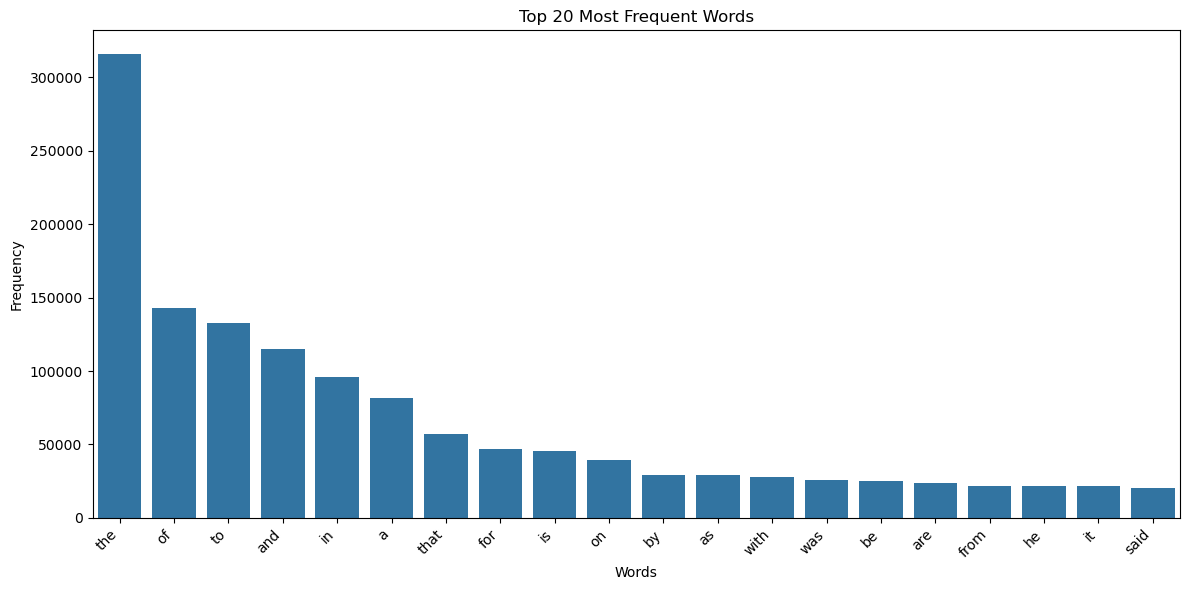

In [4]:
# Word frequency analysis
def get_top_n_words(corpus, n=10):
    words = ' '.join(corpus).lower().split()
    return Counter(words).most_common(n)

top_words = get_top_n_words(df['Content'], n=20)
plt.figure(figsize=(12, 6))
sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(top_words)

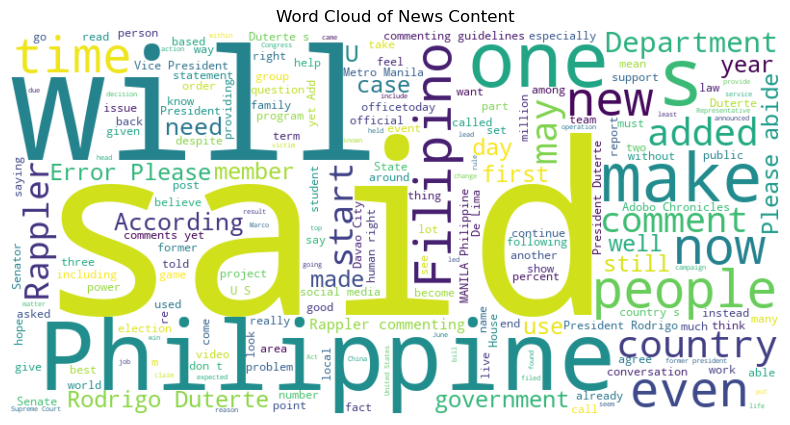

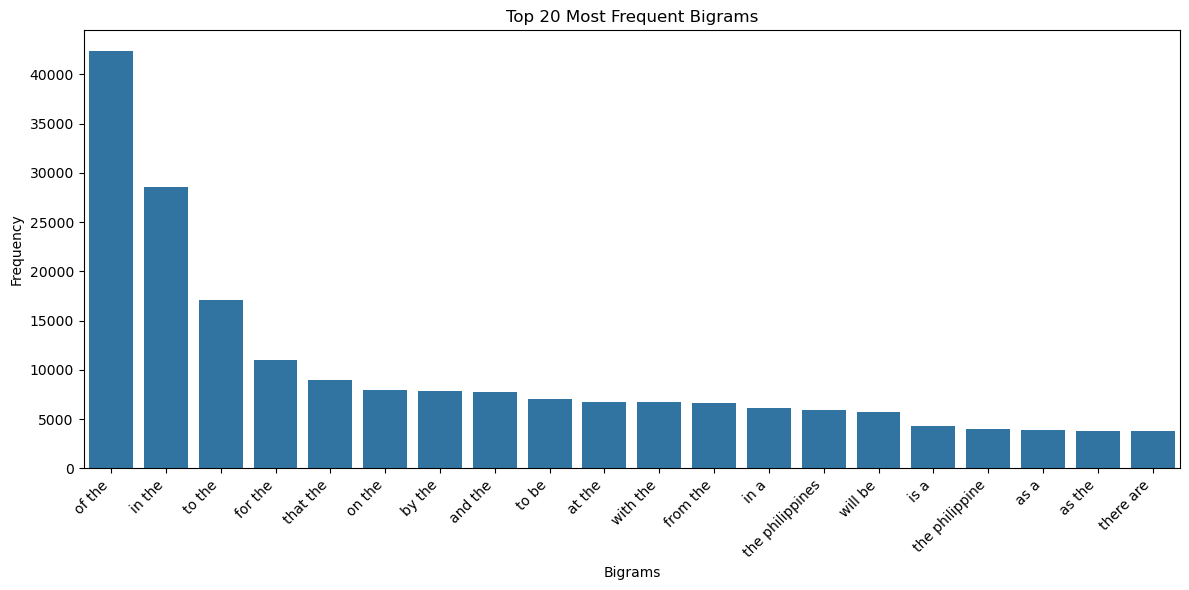

In [5]:
# Word cloud
text = ' '.join(df['Content'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Content')
plt.show()

print(wordcloud)

# N-gram analysis (bigrams)
def get_top_n_bigrams(corpus, n=10):
    bigrams = [b for l in corpus for b in zip(l.lower().split()[:-1], l.lower().split()[1:])]
    return Counter(bigrams).most_common(n)

top_bigrams = get_top_n_bigrams(df['Content'], n=20)
plt.figure(figsize=(12, 6))
sns.barplot(x=[' '.join(bigram[0]) for bigram in top_bigrams], y=[bigram[1] for bigram in top_bigrams])
plt.title('Top 20 Most Frequent Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(top_bigrams)


Processing entities: 100%|██████████| 12821/12821 [09:06<00:00, 23.48it/s]


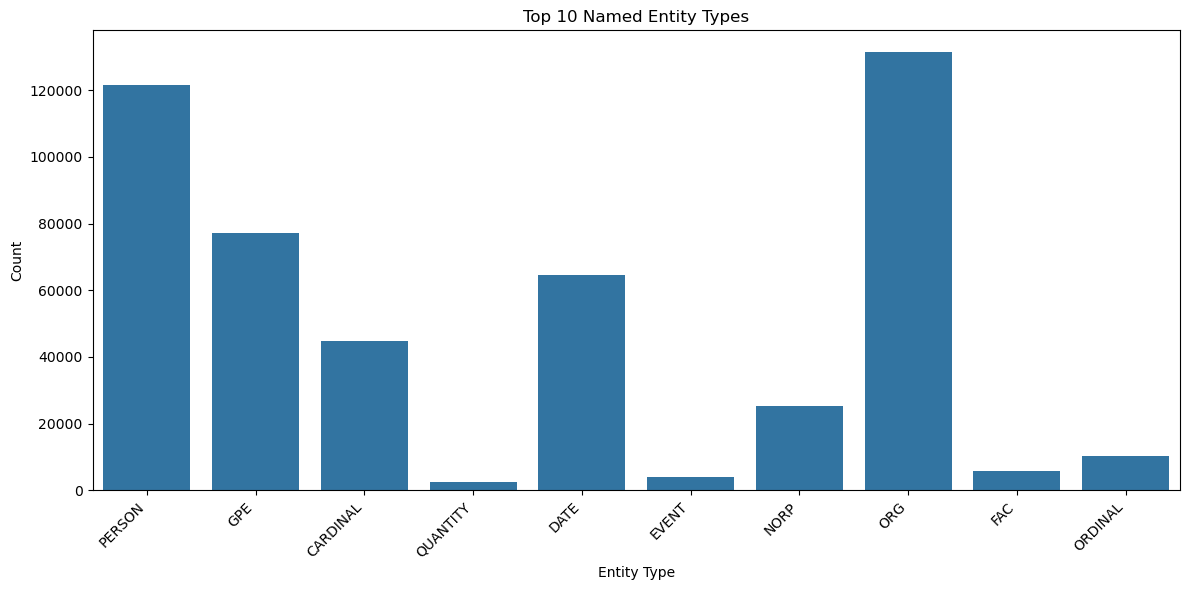

In [6]:
# Entity recognition
nlp = spacy.load("en_core_web_sm")

def get_entities(text):
    doc = nlp(text)
    return [ent.label_ for ent in doc.ents]

tqdm.pandas(desc="Processing entities")
df['entities'] = df['Content'].progress_apply(get_entities)

entity_counts = Counter([entity for entities in df['entities'] for entity in entities])


plt.figure(figsize=(12, 6))
sns.barplot(x=list(entity_counts.keys())[:10], y=list(entity_counts.values())[:10])
plt.title('Top 10 Named Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(entity_counts)


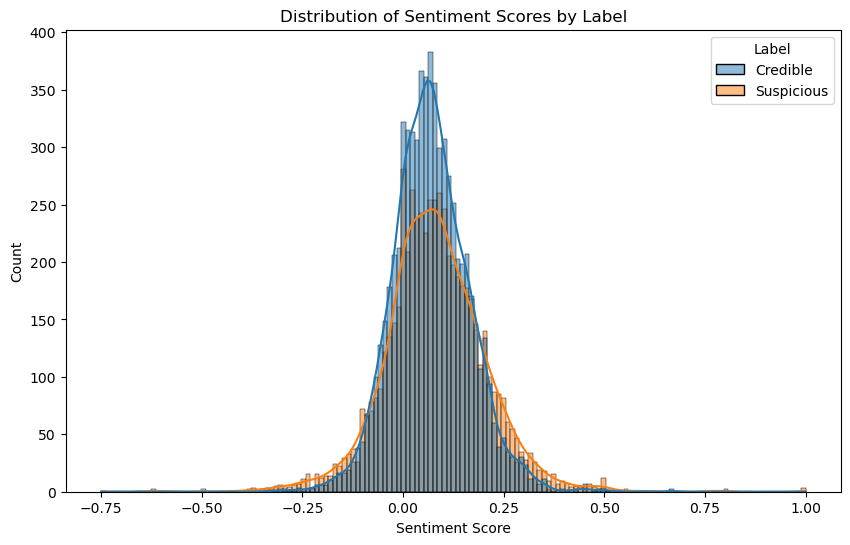

Average sentiment score: 0.07
Median sentiment score: 0.07


In [7]:
# Sentiment analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['Content'].apply(get_sentiment)

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='sentiment', hue='Label', kde=True)
plt.title('Distribution of Sentiment Scores by Label')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

print(f"Average sentiment score: {df['sentiment'].mean():.2f}")
print(f"Median sentiment score: {df['sentiment'].median():.2f}")


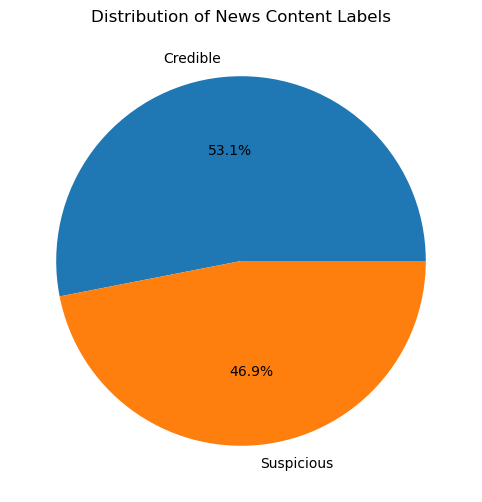

Label
Credible      0.530692
Suspicious    0.469308
Name: proportion, dtype: float64


In [8]:
# Label distribution
plt.figure(figsize=(8, 6))
df['Label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of News Content Labels')
plt.ylabel('')
plt.show()

print(df['Label'].value_counts(normalize=True))

In [30]:
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer
from torch.utils.data import Dataset as TorchDataset
from sklearn.utils.class_weight import compute_class_weight
from datasets import load_dataset
from imblearn.over_sampling import SMOTE
import numpy as np
import random
import logging
from collections import Counter

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Load the dataset from Hugging Face
dataset = load_dataset("nixbel/dataset_train_thesis")

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Define maximum sequence length
MAX_LEN = 256


# PREPROCESSING METHOD WITH HUGGING FACE

# Text cleaning function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Simple data augmentation function
def simple_augment(text):
    words = text.split()
    if len(words) > 10:
        # Randomly remove 10% of words
        num_to_remove = max(1, int(len(words) * 0.1))
        for _ in range(num_to_remove):
            index = np.random.randint(0, len(words))
            words.pop(index)
    return ' '.join(words)

# Tokenization function
def tokenize_and_pad(examples, augment=False):
    texts = [clean_text(text) for text in examples['Content']]
    
    '''if augment:
    # Apply simple augmentation to 'Suspicious' examples
        augmented_texts = []
        for text, label in zip(texts, examples['Label']):
            if label == 'Suspicious':
                augmented_texts.append(simple_augment(text))
            else:
                augmented_texts.append(text)
        
        texts.extend(augmented_texts)'''
    logger.info("Starting tokenization process.")

    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=MAX_LEN)

    # Create attention masks
    attention_masks = [[float(i != tokenizer.pad_token_id) for i in input_ids] for input_ids in encodings['input_ids']]

    labels = [1 if label == 'Suspicious' else 0 for label in examples['Label']]
    '''if augment:
        labels.extend([1] * len(augmented_texts))'''
    
    return {
        'input_ids': encodings['input_ids'],
        'attention_mask': attention_masks,
        'labels': labels
    }

# Apply tokenization and padding to the dataset
tokenized_datasets = dataset.map(tokenize_and_pad, batched=True, remove_columns=dataset['train'].column_names)

# Compute class weights to handle class imbalance
label_list = tokenized_datasets['train']['labels']
class_counts = Counter(label_list)
print(f"Class counts: {class_counts}")

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(label_list), y=label_list)
class_weights = torch.tensor(class_weights, dtype=torch.float)

print(f"Computed class weights: {class_weights}")

# Convert to PyTorch tensors
class NewsDataset(TorchDataset):
    def __init__(self, encodings):
        #self.dataset = dataset
        self.input_ids = torch.tensor(encodings['input_ids'], dtype=torch.long)
        self.attention_mask = torch.tensor(encodings['attention_mask'], dtype=torch.float)
        self.labels = torch.tensor(encodings['labels'], dtype=torch.long)

    def __getitem__(self, idx):
        #item = {key: torch.tensor(self.dataset[key][idx]) for key in self.dataset.features}# if key != 'labels'
        #item['labels'] = torch.tensor(self.dataset['labels'][idx])
        return {#item
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]}

    def __len__(self):
        return len(self.labels)
    
# Split the dataset
train_testvalid = tokenized_datasets['train'].train_test_split(test_size=0.2, seed=42)
test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

# Create datasets
def to_device(data):
    return {k: v.to(device) for k, v in data.items()}

train_dataset = NewsDataset(train_testvalid['train'])
val_dataset = NewsDataset(test_valid['train'])
test_dataset = NewsDataset(test_valid['test'])

train_dataset = [to_device(item) for item in train_dataset]
val_dataset = [to_device(item) for item in val_dataset]
#test_dataset = [to_device(item) for item in test_dataset]

print("Dataset splits:")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Verify no overlapping samples
train_input_ids = set([tuple(item['input_ids'].tolist()) for item in train_dataset])
val_input_ids = set([tuple(item['input_ids'].tolist()) for item in val_dataset])
test_input_ids = set([tuple(item['input_ids'].tolist()) for item in test_dataset])

overlap_train_val = train_input_ids.intersection(val_input_ids)
overlap_train_test = train_input_ids.intersection(test_input_ids)
overlap_val_test = val_input_ids.intersection(test_input_ids)

print(f"Overlapping samples between Train and Validation: {len(overlap_train_val)}")
print(f"Overlapping samples between Train and Test: {len(overlap_train_test)}")
print(f"Overlapping samples between Validation and Test: {len(overlap_val_test)}")

'''train_dataset = NewsDataset(tokenized_datasets['train'])

#train_dataset = train_testvalid['train']
val_dataset = test_valid['train']
test_dataset = test_valid['test']'''

'''# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(
    np.array([example['input_ids'] for example in train_dataset]),
    np.array([example['labels'] for example in train_dataset])
)

# Create attention masks for the resampled data
attention_masks_resampled = np.array([example['attention_mask'] for example in train_dataset])[smote.sample_indices_]

# Create a new balanced dataset
class BalancedDataset(TorchDataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx]),
            'attention_mask': torch.tensor(self.attention_masks[idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)


balanced_train_dataset = BalancedDataset(
    X_resampled,
    attention_masks_resampled,
    y_resampled
)'''


print("Preprocessing completed!")
# Add a progress bar
with tqdm(total=1, desc="Preprocessing datasets") as pbar:
    
    pbar.update(1)
print("Preprocessing completed!")
'''print(f"Original dataset size: {len(train_dataset)}")
print(f"Balanced dataset size: {len(balanced_train_dataset)}")
'''

'''# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples['Content'], truncation=True, padding='max_length', max_length=MAX_LEN)

# Apply tokenization to the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Prepare dataset for training
tokenized_datasets = tokenized_datasets.remove_columns(['Headline', 'Authors', 'Date', 'Brand', 'URL'])
tokenized_datasets = tokenized_datasets.rename_column("Label", "labels")
tokenized_datasets = tokenized_datasets.with_format("torch")
#tokenized_datasets = tokenized_datasets.map(convert_labels)








'''
# Verify the type of test_dataset

# After preprocessing and tokenization
class_distribution = Counter(tokenized_datasets['train']['labels'])
print(f"Class distribution: {class_distribution}")

# Correctly extracting unique labels
unique_labels = set(tokenized_datasets['train']['labels'])
assert unique_labels == {0, 1}, f"Unexpected labels found: {unique_labels}"
print("Labels are correctly encoded as 0 and 1.")

# Confirm that labels are correctly mapped in validation and test sets
val_unique_labels = set(tokenized_datasets['train']['labels'])
test_unique_labels = set(train_testvalid['test']['labels'])
assert val_unique_labels == {0, 1}, "Labels in validation set are not correctly encoded."
assert test_unique_labels == {0, 1}, "Labels in test set are not correctly encoded."
print("All datasets have correctly encoded labels.")


Class counts: Counter({0: 6804, 1: 6017})
Computed class weights: tensor([0.9422, 1.0654])
Dataset splits:
Train dataset size: 10256
Validation dataset size: 1282
Test dataset size: 1283
Overlapping samples between Train and Validation: 143
Overlapping samples between Train and Test: 144
Overlapping samples between Validation and Test: 28
Preprocessing completed!


Preprocessing datasets: 100%|██████████| 1/1 [00:00<00:00, 19784.45it/s]

Preprocessing completed!
Class distribution: Counter({0: 6804, 1: 6017})
Labels are correctly encoded as 0 and 1.
All datasets have correctly encoded labels.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,
1,No log,0.119376,0.950858,0.948822,0.904025,0.998291,0.998291
2,No log,0.069993,0.978939,0.977330,0.960396,0.994872,0.994872
3,No log,0.276405,0.978939,0.976460,0.996441,0.957265,0.957265


Computed metrics: {'accuracy': 0.9508580343213728, 'f1': 0.9488220958570268, 'precision': 0.9040247678018576, 'recall': 0.9982905982905983}
Computed metrics: {'accuracy': 0.9789391575663027, 'f1': 0.9773299748110831, 'precision': 0.9603960396039604, 'recall': 0.9948717948717949}
Computed metrics: {'accuracy': 0.9789391575663027, 'f1': 0.976460331299041, 'precision': 0.99644128113879, 'recall': 0.9572649572649573}
Best model saved to ./results/best_model
Best model has been successfully saved and is safe.


Computed metrics: {'accuracy': 0.9501169134840218, 'f1': 0.9479674796747968, 'precision': 0.919558359621451, 'recall': 0.9781879194630873}
Test results: PredictionOutput(predictions=array([[-2.228151  ,  1.8189431 ],
       [-0.489539  ,  0.34571454],
       [-1.0943235 ,  0.78832895],
       ...,
       [-1.9079151 ,  1.5495154 ],
       [-1.579477  ,  1.2803965 ],
       [ 2.3265889 , -2.16568   ]], dtype=float32), label_ids=array([1, 0, 0, ..., 1, 1, 0]), metrics={'test_loss': 0.12028530985116959, 'test_accuracy': 0.9501169134840218, 'test_f1': 0.9479674796747968, 'test_precision': 0.919558359621451, 'test_recall': 0.9781879194630873, 'accuracy': 0.9501169134840218, 'f1': 0.9479674796747968, 'precision': 0.919558359621451, 'recall': 0.9781879194630873, 'test_runtime': 5.3194, 'test_samples_per_second': 241.193, 'test_steps_per_second': 3.948})
Final Confusion Matrix:


Computed metrics: {'accuracy': 0.9501169134840218, 'f1': 0.9479674796747968, 'precision': 0.919558359621451, 'recall': 0.9781879194630873}


Computed metrics: {'accuracy': 0.9508580343213728, 'f1': 0.9488220958570268, 'precision': 0.9040247678018576, 'recall': 0.9982905982905983}
Validation Results: PredictionOutput(predictions=array([[ 2.3178914 , -2.254904  ],
       [-0.32759103,  0.23330252],
       [-2.652511  ,  2.1884813 ],
       ...,
       [-2.289227  ,  1.9372252 ],
       [-0.5033342 ,  0.35346985],
       [ 1.86055   , -1.9173017 ]], dtype=float32), label_ids=array([0, 0, 1, ..., 1, 1, 0]), metrics={'test_loss': 0.11937564611434937, 'test_accuracy': 0.9508580343213728, 'test_f1': 0.9488220958570268, 'test_precision': 0.9040247678018576, 'test_recall': 0.9982905982905983, 'accuracy': 0.9508580343213728, 'f1': 0.9488220958570268, 'precision': 0.9040247678018576, 'recall': 0.9982905982905983, 'test_runtime': 5.3055, 'test_samples_per_second': 241.634, 'test_steps_per_second': 3.958})
Unique predictions: [0 1]
Unique true labels: [0 1]
True label: 1, Predicted label: 1
True label: 0, Predicted label: 1
True label: 

Computed metrics: {'accuracy': 0.9501169134840218, 'f1': 0.9479674796747968, 'precision': 0.919558359621451, 'recall': 0.9781879194630873}
Test Results: {'test_loss': 0.12028530985116959, 'test_accuracy': 0.9501169134840218, 'test_f1': 0.9479674796747968, 'test_precision': 0.919558359621451, 'test_recall': 0.9781879194630873, 'accuracy': 0.9501169134840218, 'f1': 0.9479674796747968, 'precision': 0.919558359621451, 'recall': 0.9781879194630873, 'test_runtime': 5.3276, 'test_samples_per_second': 240.82, 'test_steps_per_second': 3.942}


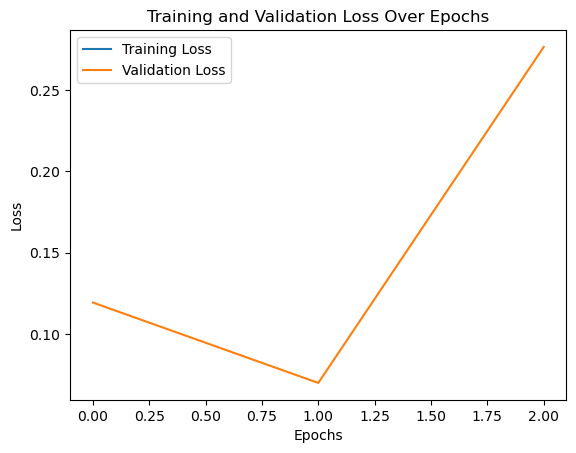

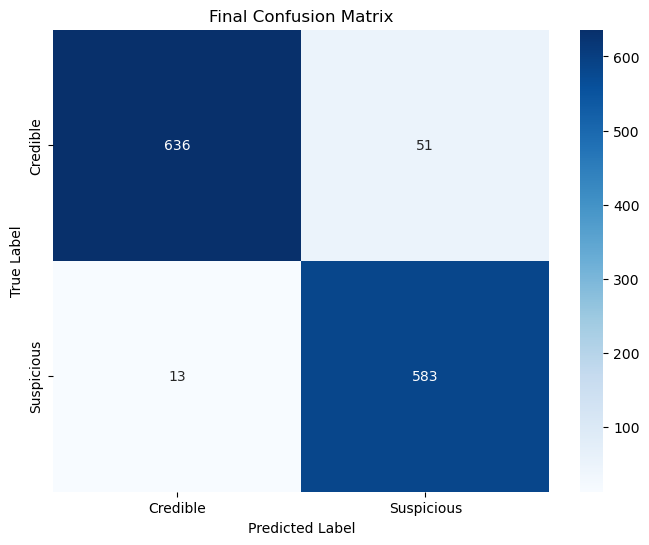


Classification Report:
              precision    recall  f1-score   support

    Credible       0.98      0.93      0.95       687
  Suspicious       0.92      0.98      0.95       596

    accuracy                           0.95      1283
   macro avg       0.95      0.95      0.95      1283
weighted avg       0.95      0.95      0.95      1283



In [33]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments, get_linear_schedule_with_warmup, EarlyStoppingCallback, EvalPrediction
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import numpy as np
import psutil
import os

# Load pre-trained model
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
model.to(device)

#Implement Early Stopping
early_stopping = EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.01)


# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    gradient_accumulation_steps=1,
    fp16=True,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save at the end of each epoch
    load_best_model_at_end=True,  # Load the best model when finished training
    metric_for_best_model="f1",  # Use eval loss to identify the best model
    greater_is_better=False,
    learning_rate=2e-5,
    max_grad_norm=1.0,
    dataloader_pin_memory=False,
    logging_strategy="epoch",  # Activate logging for each epoch
    report_to="none", 
)


# Create a custom Trainer class to clear cache after each epoch


    
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(device) if class_weights is not None else None

    def evaluation_loop(self, eval_dataset, description, prediction_loss_only=None, ignore_keys=None, metric_key_prefix="eval"):
        #print("Starting evaluation...")
        output = super().evaluation_loop(eval_dataset, description, prediction_loss_only, ignore_keys, metric_key_prefix)
        
        if self.compute_metrics is not None and output.predictions is not None:
            # Compute metrics using the output
            eval_preds = EvalPrediction(predictions=output.predictions, label_ids=output.label_ids)
            metrics = self.compute_metrics(eval_preds)

        # Add the computed metrics to the output
        output.metrics.update(metrics)

        print("Computed metrics:", metrics)
        
        return output
    
    def _maybe_log_save_evaluate(self, tr_loss, model, trial, epoch, ignore_keys_for_eval, grad_norm=None):
        if self.control.should_evaluate:
            metrics = self.evaluate()
            self._report_to_hp_search(trial, epoch, metrics)
            self.control = self.callback_handler.on_evaluate(self.args, self.state, self.control, metrics)
            #self._report_progress(metrics)

        if self.control.should_save:
            self._save_checkpoint(model, trial, metrics=metrics)
            self.control = self.callback_handler.on_save(self.args, self.state, self.control)
    

    def compute_loss(self, model, inputs, return_outputs=False):
        #labels = inputs.get("labels")

        if "labels" not in inputs:
            # If labels are not provided, create dummy labels
            labels = torch.zeros(inputs["input_ids"].shape[0], dtype=torch.long, device=inputs["input_ids"].device)
        else:
            labels = inputs.pop("labels")
            
        outputs = model(**inputs)
        logits = outputs.get("logits")

        '''# Debug information
        print(f"Inputs: {inputs.keys()}")
        print(f"Labels shape: {labels.shape if labels is not None else None}")
        print(f"Logits shape: {logits.shape if logits is not None else None}")'''
        
        if logits is None:
            print("Warning: logits is None. Model output:", outputs)
            # Return a dummy loss if logits is None
            dummy_loss = torch.tensor(0.0, requires_grad=True)
            return (dummy_loss, outputs) if return_outputs else dummy_loss
        
        
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss
    
    
        

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)

    # Compute confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png')
    plt.close()

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }





# Create Trainer
trainer = CustomTrainer(
    model=model,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping],
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    class_weights=class_weights
)



# Train the model
trainer.train()



# Save the best model
'''best_model_path = os.path.join(training_args.output_dir, "best_model")
trainer.save_model(best_model_path)
print(f"Best model saved to {best_model_path}")'''

best_model_path = os.path.join(training_args.output_dir, "best_model")
trainer.save_model(best_model_path)
print(f"Best model saved to {best_model_path}")

# Check if the saved model exists
if os.path.exists(best_model_path):
    print("Best model has been successfully saved and is safe.")
else:
    print("Warning: Best model could not be found at the specified path.")

# To load the best model
model = RobertaForSequenceClassification.from_pretrained(best_model_path, num_labels=2)
model.to(device)

test_results = trainer.predict(test_dataset)
print(f"Test results: {test_results}")




# Print final confusion matrix
print("Final Confusion Matrix:")
# Perform prediction
test_predictions = trainer.predict(test_dataset)
# Extract true labels and predicted labels from the PredictionOutput
true_labels = test_predictions.label_ids
predicted_labels = np.argmax(test_predictions.predictions, axis=-1)


val_results = trainer.predict(val_dataset)
val_true = val_results.label_ids
val_preds = np.argmax(val_results.predictions, axis=-1)
print(f"Validation Results: {val_results}")

# Check unique predictions and labels
unique_preds = np.unique(predicted_labels)
unique_true = np.unique(true_labels)
print(f"Unique predictions: {unique_preds}")
print(f"Unique true labels: {unique_true}")

for i in range(5):
    print(f"True label: {true_labels[i]}, Predicted label: {predicted_labels[i]}")

# Inspect a larger subset of predictions
for i in range(20):
    print(f"Text: {train_testvalid['test']['input_ids'][i]}")
    print(f"True Label: {true_labels[i]}, Predicted Label: {predicted_labels[i]}")
    print("-----")

# Evaluate on Test Set
test_results = trainer.predict(test_dataset)
print(f"Test Results: {test_results.metrics}")


# Assuming you have access to trainer's history
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Credible', 'Suspicious'], yticklabels=['Credible', 'Suspicious'])
plt.title('Final Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=['Credible', 'Suspicious']))